# This is for the final model with xLSTM and dropout layers

In [ ]:
!pip install xLSTM
!pip install ninja
!pip install xlstm --force-reinstall --no-cache-dir


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 23.8 MB/s eta 0:00:00
  Attempting uninstall: xlstm
    Found existing installation: xlstm 1.0.8
    Uninstalling xlstm-1.0.8:
      Successfully uninstalled xlstm-1.0.8


In [ ]:
import json
import torch
from torch import nn

from sklearn.model_selection import train_test_split
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [ ]:
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Hyperparameters / Variability management
DATALOADING_DATA_PATH = "insert_file_path/all_tunes_cleaned_removed_whitespace.txt"
DATALOADING_VOCAB_PATH = "insert_file_path/char_to_idx_truncated.json"

DATASET_SEQUENCE_LENGTH = 128
LOADER_BATCH_SIZE = 126

MODEL_EMBEDDING_DIM = 128 # Dimension of the embedding
MODEL_HIDDEN_SIZE = 256 # LSTM layer size
MODEL_LSTM_LAYERS = 4 # Number of LSTM layers
MODEL_SAVE_PATH =   'insert_file_path/final_xLSTM_model.pt'

TRAINING_EPOCHS = 15

RESULTS_LOAD_PATH =  'insert_file_path/final_model_weights.pt'

In [ ]:
with open(DATALOADING_DATA_PATH, "r") as f:
  data = f.read()

with open(DATALOADING_VOCAB_PATH) as f:
    char_to_index = json.load(f)
    index_to_char = {index: char for char, index in char_to_index.items()} # To transfer back

In [ ]:
data_translated = [char_to_index[char] for char in data]
data_translated = data_translated[:len(data_translated) // 250] # Truncate data

In [ ]:
# Define the data set
# WARNING: TAKES TRANSLATED DATA FORMAT
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self,
                 X, # The data in TRANSLATED FORMAT
                 sequence_len=1, # How much context does the model have?
                 ):

        self.X=torch.tensor(X, dtype=torch.long)
        self.sequence_len=sequence_len

    def __len__(self):
      # Make room for a last sequence and its target, hence the 1 also
        return len(self.X) - self.sequence_len - 1


    def __getitem__(self,idx):
        X = self.X[idx:idx+self.sequence_len] # 1 x sequence_len
        Ytarget = self.X[idx+self.sequence_len] # 1 x 1
        return X, Ytarget.long() # For dimensions to match LSTM layer :)

In [ ]:
dataset = MusicDataset(X=data_translated, sequence_len=DATASET_SEQUENCE_LENGTH)

train_idx, test_idx = train_test_split(range(len(dataset)), test_size=.1, shuffle=False)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

In [ ]:
import torch
from torch import nn
from xlstm import xLSTMBlockStack, xLSTMBlockStackConfig, mLSTMBlockConfig, mLSTMLayerConfig, sLSTMBlockConfig, sLSTMLayerConfig, FeedForwardConfig

class SimpleModelWithxLSTM(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_dim,
                 hidden_size,
                 context_length,
                 num_blocks,
                 slstm_at,
                 dropout_prob = 0.5):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )


        # xLSTM configuration
        self.xLSTM_cfg = xLSTMBlockStackConfig(
            mlstm_block=mLSTMBlockConfig(
                mlstm=mLSTMLayerConfig(
                    conv1d_kernel_size=4,
                    qkv_proj_blocksize=4,
                    num_heads=4
                )
            ),
            slstm_block=sLSTMBlockConfig(
                slstm=sLSTMLayerConfig(
                    backend="vanilla",
                    num_heads=4,
                    conv1d_kernel_size=4,
                    bias_init="powerlaw_blockdependent",
                ),
                feedforward=FeedForwardConfig(
                    proj_factor=1.3,
                    act_fn="gelu"
                ),
            ),
            context_length=context_length,
            num_blocks=num_blocks,
            embedding_dim=embedding_dim,
            slstm_at=slstm_at,
        )

        # Initialize xLSTM stack
        self.xLSTM = xLSTMBlockStack(self.xLSTM_cfg)

        self.dropout_1 = nn.Dropout(dropout_prob)


        # Fully connected layers
        self.fc1 = nn.Linear(embedding_dim, hidden_size)
        self.dropout_2 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, vocab_size)


    def forward(self, x):
        # Embed the input
        x = self.embedding(x)  # Shape: [batch_size, seq_length, embedding_dim]

        # Pass through the xLSTM stack
        x = self.xLSTM(x)  # Shape: [batch_size, seq_length, embedding_dim]

        x = self.dropout_1(x)
        # Take the last sequence step (e.g., for classification tasks)
        x = x[:, -1, :]  # Shape: [batch_size, embedding_dim]

        # Fully connected layers
        x = self.fc1(x)  # Shape: [batch_size, hidden_size]
        x = nn.functional.relu(x)
        x = self.dropout_2(x)
        x = self.fc2(x)  # Shape: [batch_size, vocab_size]

        return x

In [ ]:
VOCAB_SIZE = 95 #len(char_to_index)
EMBEDDING_DIM = MODEL_EMBEDDING_DIM
HIDDEN_SIZE = MODEL_HIDDEN_SIZE
CONTEXT_LENGTH = DATASET_SEQUENCE_LENGTH
NUM_BLOCKS = 4  # Number of xLSTM blocks
SLSTM_AT = [1]  # Use sLSTM at specific layers

# Initialize the model
model = SimpleModelWithxLSTM(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    context_length=CONTEXT_LENGTH,
    num_blocks=NUM_BLOCKS,
    slstm_at=SLSTM_AT
).to(device)


n_epochs = TRAINING_EPOCHS

loss_fn = nn.CrossEntropyLoss() # Because character classification task
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
batch_size = LOADER_BATCH_SIZE


train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
# Sanity check loss function
for x_batch, y_batch in train_loader:
  x_batch, y_batch = x_batch.to(device), y_batch.to(device)
  break

print("X batch dim:", x_batch.shape)
print("y batch dim:", y_batch.shape)


model_output = model(x_batch)
print("y_pred dim:", model_output.shape)

loss_fn(model_output, y_batch)

X batch dim: torch.Size([126, 128])
y batch dim: torch.Size([126])
y_pred dim: torch.Size([126, 95])


tensor(4.6346, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:

# TEST EVAL RUN
model.eval()
test_loss = 0
test_accuracy = 0

with torch.no_grad():
    for batch_number, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)
        test_loss += loss.item()

        test_accuracy += (y_pred.argmax(dim=1) == y_batch).sum().item()

        if batch_number % 1000 == 0:
          print(f"Batch {batch_number + 1}/{len(test_loader)}")

print(f"Accuracy {test_accuracy / len(test_dataset) * 100:.4f}%")
print(f"Initial loss: {test_loss / len(test_dataset):.4f}")

Batch 1/148
Accuracy 1.4016%
Initial loss: 0.0363


In [ ]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

def train(model, optimizer, loss_fn, train_loader):
    model.train()
    correct_predictions = 0
    total_samples = 0
    losses = 0

    for batch_number, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients (only if necessary)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        losses += loss.item()
        correct_predictions += (y_pred.argmax(dim=1) == y_batch).sum().item()
        total_samples += y_batch.size(0)

        if batch_number % 1000 == 0:
            print(f"Batch {batch_number + 1}/{len(train_loader)}")

        torch.cuda.empty_cache()

    train_loss.append(losses / len(train_loader))
    train_accuracy.append(correct_predictions / total_samples)
    print(f"Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_accuracy[-1] * 100:.2f}%")


def test(model, loss_fn, test_loader):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    losses = 0

    with torch.no_grad():
        for batch_number, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)

            loss = loss_fn(y_pred, y_batch)

            losses += loss.item()
            correct_predictions += (y_pred.argmax(dim=1) == y_batch).sum().item()
            total_samples += y_batch.size(0)

            if batch_number % 1000 == 0:
                print(f"Batch {batch_number + 1}/{len(test_loader)}")

    torch.cuda.empty_cache()

    test_loss.append(losses / len(test_loader))
    test_accuracy.append(correct_predictions / total_samples)
    print(f"Test Loss: {test_loss[-1]:.4f}, Test Accuracy: {test_accuracy[-1] * 100:.2f}%")

In [ ]:
# patience = 2
# best_loss = float('inf')
# epochs_without_improvement = 0

model_hidden_size_list = [128, 256]
lstm_layers_list = [2, 4]

model_dict_dropout = dict()

for model_hidden_size, lstm_layers in zip(model_hidden_size_list, lstm_layers_list):
    print(f"Model hidden size: {model_hidden_size}, LSTM layers: {lstm_layers}")
    model = SimpleModelWithxLSTM(
          vocab_size=VOCAB_SIZE,
          embedding_dim=EMBEDDING_DIM,
          hidden_size=model_hidden_size,
          context_length=CONTEXT_LENGTH,
          num_blocks=lstm_layers,
          slstm_at=SLSTM_AT
      ).to(device)

    loss_fn = nn.CrossEntropyLoss() # Because character classification task
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    model_results = {
        'train_loss': [],
        'test_loss': [],
        'train_accuracy': [],
        'test_accuracy': []
    }

    # Training loop
    for epoch in range(n_epochs):
        if epoch % 1 == 0:
            print(f"Epoch {epoch}/{n_epochs}")

        # Train and test the model
        train(model, optimizer, loss_fn, train_loader)
        test(model, loss_fn, test_loader)

        # Save metrics for this epoch
        model_results['train_loss'].append(train_loss[-1])
        model_results['test_loss'].append(test_loss[-1])
        model_results['train_accuracy'].append(train_accuracy[-1])
        model_results['test_accuracy'].append(test_accuracy[-1])
        print(model_results)

    # Store the results for this model configuration in the dictionary
    model_dict_dropout[(model_hidden_size, lstm_layers)] = model_results


# for epoch in range(n_epochs):
#   if epoch % 1 == 0:
#     print(f"Epoch {epoch}/{n_epochs}")
#   train(model, optimizer, loss_fn, train_loader)
#   test(model, loss_fn, test_loader)

#   if test_loss[-1] < best_loss:
#     best_loss = test_loss[-1]
#     epochs_without_improvement = 0

#   else:
#     epochs_without_improvement += 1
#   if epochs_without_improvement >= patience:
#     print("Early stopping triggered.")
#     break

Model hidden size: 128, LSTM layers: 2
Epoch 0/15
Batch 1/1331
Batch 1001/1331
Train Loss: 2.4630, Train Accuracy: 29.90%
Batch 1/148
Test Loss: 2.0714, Test Accuracy: 38.39%
{'train_loss': [2.4630188775367077], 'test_loss': [2.0713664309398547], 'train_accuracy': [0.29897245560435365], 'test_accuracy': [0.38386767627946944]}
Epoch 1/15
Batch 1/1331
Batch 1001/1331
Train Loss: 2.0201, Train Accuracy: 40.02%
Batch 1/148
Test Loss: 1.9397, Test Accuracy: 41.37%
{'train_loss': [2.4630188775367077, 2.0201199234741063], 'test_loss': [2.0713664309398547, 1.9396705861027177], 'train_accuracy': [0.29897245560435365, 0.40024107313347335], 'test_accuracy': [0.38386767627946944, 0.4136727350840449]}
Epoch 2/15
Batch 1/1331
Batch 1001/1331
Train Loss: 1.8858, Train Accuracy: 43.60%
Batch 1/148
Test Loss: 1.8826, Test Accuracy: 43.70%
{'train_loss': [2.4630188775367077, 2.0201199234741063, 1.8858480137331337], 'test_loss': [2.0713664309398547, 1.9396705861027177, 1.8826304939953056], 'train_accurac

In [ ]:
train_loss

In [ ]:
test_loss

In [ ]:
train_accuracy

In [ ]:
char_to_index.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94])

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(test_loss)), test_loss, label='test')
plt.title("Loss plot of train and test loss function")
plt.legend()
plt.show()

In [ ]:
plt.plot(range(len(train_accuracy)), train_accuracy, label='train')
plt.plot(range(len(test_accuracy)), test_accuracy, label='test')
plt.title("Loss plot of train and test accuracy")
plt.legend()
plt.show()


## Grid search

In [ ]:

from sklearn.base import BaseEstimator, ClassifierMixin


class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 vocab_size,
                 embedding_dim=128,
                 hidden_size=256,
                 context_length=128,
                 num_blocks=7,
                 slstm_at=[1],
                 batch_size=32, # hyperparams from here
                 dropout_prob=0.5,
                 learning_rate=0.001,
                 epochs=1):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.context_length = context_length
        self.num_blocks = num_blocks
        self.slstm_at = slstm_at
        self.dropout_prob = dropout_prob
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = None

    def fit(self, X, y):

        X = torch.tensor(X, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)
        """
        setting the classes totally fucks the vram, it tries to allocate
        80gb no matter the batchsize. I have no clue why
        """
        self.classes_ = list(set(y.numpy()))

        train_loader = torch.utils.data.DataLoader(list(zip(X, y)), batch_size=self.batch_size, shuffle=True)

        self.model = SimpleModelWithxLSTM(
            vocab_size=self.vocab_size,
            embedding_dim=self.embedding_dim,
            hidden_size=self.hidden_size,
            context_length=self.context_length,
            num_blocks=self.num_blocks,
            slstm_at=self.slstm_at).to(self.device)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        loss_fn = nn.CrossEntropyLoss()


        for epoch in range(self.epochs):
            train(self.model, optimizer, loss_fn, train_loader)
            torch.cuda.empty_cache()


    def predict(self, X):
        X = torch.tensor(X, dtype=torch.long).to(self.device)
        self.model.eval()
        with torch.no_grad():
          y_pred = self.model(X)

        torch.cuda.empty_cache()
        return torch.argmax(y_pred, dim=1).cpu().numpy()

    def score(self, X, y):

        X_tensor = torch.LongTensor(X)
        y_tensor = torch.LongTensor(y)
        test_loader = torch.utils.data.DataLoader(list(zip(X_tensor, y_tensor)), batch_size=self.batch_size, shuffle=False)

        # Evaluate model
        test(self.model, nn.CrossEntropyLoss(), test_loader)

        # Return accuracy
        return test_accuracy[-1]



In [ ]:
import numpy as np

def dataloader_to_arrays(dataloader):
    X = []
    y = []
    for x_batch, y_batch in dataloader:
        X.append(x_batch.numpy())
        y.append(y_batch.numpy())
    X = np.concatenate(X)
    y = np.concatenate(y)
    return X, y

In [ ]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.001, 0.0001, 0.00001],
    'dropout_prob': [0.3, 0.5, 0.7]
}

pytorch_clf = PyTorchClassifier(vocab_size=VOCAB_SIZE)

X_train, y_train = dataloader_to_arrays(train_loader)
X_test, y_test = dataloader_to_arrays(test_loader)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=pytorch_clf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Batch 1/435
Train Loss: 2.8851, Train Accuracy: 21.26%
Batch 1/435
Train Loss: 2.8845, Train Accuracy: 21.85%
Batch 1/435
Train Loss: 2.9021, Train Accuracy: 21.21%
Batch 1/435
Train Loss: 3.6499, Train Accuracy: 9.42%
Batch 1/435
Train Loss: 3.6698, Train Accuracy: 9.19%
Batch 1/435
Train Loss: 3.6314, Train Accuracy: 9.07%
Batch 1/435
Train Loss: 4.5375, Train Accuracy: 1.61%
Batch 1/435
Train Loss: 4.4984, Train Accuracy: 2.78%
Batch 1/435
Train Loss: 4.5068, Train Accuracy: 2.13%
Batch 1/435
Train Loss: 2.9025, Train Accuracy: 21.20%
Batch 1/435
Train Loss: 2.8895, Train Accuracy: 21.54%
Batch 1/435
Train Loss: 2.8842, Train Accuracy: 21.32%
Batch 1/435
Train Loss: 3.6495, Train Accuracy: 9.38%
Batch 1/435
Train Loss: 3.6388, Train Accuracy: 9.40%
Batch 1/435
Train Loss: 3.6577, Train Accuracy: 9.38%
Batch 1/435
Train Loss: 4.4726, Train Accuracy: 2.69%
Batch 1/435
Train Loss: 4.5240, Train Accuracy: 2.05%
Batch 1/435
Train Loss: 4.5128, Train Accuracy: 2.13%
Batch 1/435
Train Loss

In [ ]:
torch.cuda.empty_cache()

In [ ]:
x = ["din"]

In [ ]:
torch.summary(model)

In [ ]:
"""/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
Batch 1/435
Train Loss: 2.8851, Train Accuracy: 21.26%
Batch 1/435
Train Loss: 2.8845, Train Accuracy: 21.85%
Batch 1/435
Train Loss: 2.9021, Train Accuracy: 21.21%
Batch 1/435
Train Loss: 3.6499, Train Accuracy: 9.42%
Batch 1/435
Train Loss: 3.6698, Train Accuracy: 9.19%
Batch 1/435
Train Loss: 3.6314, Train Accuracy: 9.07%
Batch 1/435
Train Loss: 4.5375, Train Accuracy: 1.61%
Batch 1/435
Train Loss: 4.4984, Train Accuracy: 2.78%
Batch 1/435
Train Loss: 4.5068, Train Accuracy: 2.13%
Batch 1/435
Train Loss: 2.9025, Train Accuracy: 21.20%
Batch 1/435
Train Loss: 2.8895, Train Accuracy: 21.54%
Batch 1/435
Train Loss: 2.8842, Train Accuracy: 21.32%
Batch 1/435
Train Loss: 3.6495, Train Accuracy: 9.38%
Batch 1/435
Train Loss: 3.6388, Train Accuracy: 9.40%
Batch 1/435
Train Loss: 3.6577, Train Accuracy: 9.38%
Batch 1/435
Train Loss: 4.4726, Train Accuracy: 2.69%
Batch 1/435
Train Loss: 4.5240, Train Accuracy: 2.05%
Batch 1/435
Train Loss: 4.5128, Train Accuracy: 2.13%
Batch 1/435
Train Loss: 2.8977, Train Accuracy: 20.85%
Batch 1/435
Train Loss: 2.8959, Train Accuracy: 21.90%
Batch 1/435
Train Loss: 2.8731, Train Accuracy: 22.53%
Batch 1/435
Train Loss: 3.6747, Train Accuracy: 9.89%
Batch 1/435
Train Loss: 3.6692, Train Accuracy: 8.79%
Batch 1/435
Train Loss: 3.6588, Train Accuracy: 8.97%
Batch 1/435
Train Loss: 4.5404, Train Accuracy: 1.85%
Batch 1/435
Train Loss: 4.4838, Train Accuracy: 2.73%
Batch 1/435
Train Loss: 4.4962, Train Accuracy: 1.73%
Batch 1/652
Train Loss: 2.7251, Train Accuracy: 25.46%
Best Parameters: {'dropout_prob': 0.7, 'learning_rate': 0.001}
Best CV Score: 0.32535334540748523"""

"/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.\n  warnings.warn(\nBatch 1/435\nTrain Loss: 2.8851, Train Accuracy: 21.26%\nBatch 1/435\nTrain Loss: 2.8845, Train Accuracy: 21.85%\nBatch 1/435\nTrain Loss: 2.9021, Train Accuracy: 21.21%\nBatch 1/435\nTrain Loss: 3.6499, Train Accuracy: 9.42%\nBatch 1/435\nTrain Loss: 3.6698, Train Accuracy: 9.19%\nBatch 1/435\nTrain Loss: 3.6314, Train Accuracy: 9.07%\nBatch 1/435\nTrain Loss: 4.5375, Train Accuracy: 1.61%\nBatch 1/435\nTrain Loss: 4.4984, Train Accuracy: 2.78%\nBatch 1/435\nTrain Loss: 4.5068, Train Accuracy: 2.13%\nBatch 1/435\nTrain Loss: 2.9025, Train Accuracy: 21.20%\nBatch 1/435\nTrain Loss: 2.8895, Train Accuracy: 21.54%\nBatch 1/435\nTrain Loss: 2.8842, Train Accuracy: 21.32%\nBatch 1/435\nTrain Loss: 3.6495, Train Accuracy: 9.38%\nBatch 1/435\nTrain Loss: 3.6388, Train Accuracy: 9.40%\nBatch 1/435\nTra

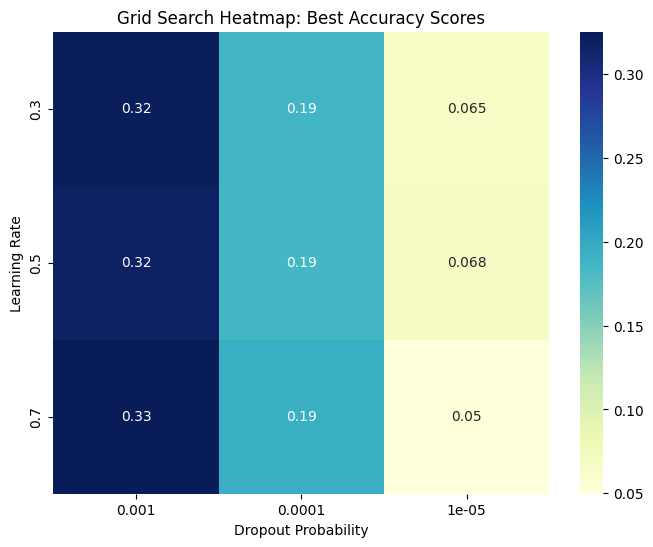

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

results = grid_search.cv_results_



best_scores = np.array(results['mean_test_score'])

# Reshape the best scores into a 2D grid for plotting (based on the length of parameter lists)
score_matrix = best_scores.reshape(len(param_grid['learning_rate']), len(param_grid['dropout_prob']))

# Create a heatmap of the grid search results
plt.figure(figsize=(8, 6))
sns.heatmap(score_matrix,
            annot=True,
            cmap='YlGnBu',
            xticklabels=param_grid['learning_rate'],
            yticklabels=param_grid['dropout_prob'])

plt.xlabel('Dropout Probability')
plt.ylabel('Learning Rate')
plt.title('Grid Search Heatmap: Best Accuracy Scores')
plt.show()

In [ ]:
results

In [ ]:
import torch
from torch import nn
from xlstm import xLSTMBlockStack, xLSTMBlockStackConfig, mLSTMBlockConfig, mLSTMLayerConfig, sLSTMBlockConfig, sLSTMLayerConfig, FeedForwardConfig

class SimpleModelWithxLSTM(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_dim,
                 hidden_size,
                 context_length,
                 num_blocks,
                 slstm_at,
                 dropout_prob = 0.5):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )


        # xLSTM configuration
        self.xLSTM_cfg = xLSTMBlockStackConfig(
            mlstm_block=mLSTMBlockConfig(
                mlstm=mLSTMLayerConfig(
                    conv1d_kernel_size=4,
                    qkv_proj_blocksize=4,
                    num_heads=4
                )
            ),
            slstm_block=sLSTMBlockConfig(
                slstm=sLSTMLayerConfig(
                    backend="vanilla",
                    num_heads=4,
                    conv1d_kernel_size=4,
                    bias_init="powerlaw_blockdependent",
                ),
                feedforward=FeedForwardConfig(
                    proj_factor=1.3,
                    act_fn="gelu"
                ),
            ),
            context_length=context_length,
            num_blocks=num_blocks,
            embedding_dim=embedding_dim,
            slstm_at=slstm_at,
        )

        # Initialize xLSTM stack
        self.xLSTM = xLSTMBlockStack(self.xLSTM_cfg)

        self.dropout_1 = nn.Dropout(dropout_prob)


        # Fully connected layers
        self.fc1 = nn.Linear(embedding_dim, hidden_size)
        self.dropout_2 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, vocab_size)


    def forward(self, x):
        # Embed the input
        x = self.embedding(x)  # Shape: [batch_size, seq_length, embedding_dim]

        # Pass through the xLSTM stack
        x = self.xLSTM(x)  # Shape: [batch_size, seq_length, embedding_dim]

        x = self.dropout_1(x)
        # Take the last sequence step (e.g., for classification tasks)
        x = x[:, -1, :]  # Shape: [batch_size, embedding_dim]

        # Fully connected layers
        x = self.fc1(x)  # Shape: [batch_size, hidden_size]
        x = nn.functional.relu(x)
        x = self.dropout_2(x)
        x = self.fc2(x)  # Shape: [batch_size, vocab_size]

        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [ ]:
VOCAB_SIZE = 95
EMBEDDING_DIM = 128
HIDDEN_SIZE = 128
CONTEXT_LENGTH = 128
NUM_BLOCKS = 2  # Number of xLSTM blocks
SLSTM_AT = [1]  # Use sLSTM at specific layers

# Initialize the model
model = SimpleModelWithxLSTM(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    context_length=CONTEXT_LENGTH,
    num_blocks=NUM_BLOCKS,
    slstm_at=SLSTM_AT
).to(device)


n_epochs = TRAINING_EPOCHS

loss_fn = nn.CrossEntropyLoss() # Because character classification task
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
model_weights = "insert_file_path"
model.load_state_dict(torch.load(model_weights))
model.eval()  # Set model to evaluation mode

In [ ]:
# Define the data set
# WARNING: TAKES TRANSLATED DATA FORMAT
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self,
                 X, # The data in TRANSLATED FORMAT
                 sequence_len=1, # How much context does the model have?
                 ):

        self.X=torch.tensor(X, dtype=torch.long)
        self.sequence_len=sequence_len

    def __len__(self):
      # Make room for a last sequence and its target, hence the 1 also
        return len(self.X) - self.sequence_len - 1


    def __getitem__(self,idx):
        X = self.X[idx:idx+self.sequence_len] # 1 x sequence_len
        Ytarget = self.X[idx+self.sequence_len] # 1 x 1
        return X, Ytarget.long() # For dimensions to match LSTM layer :)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_weights = "/insert_file_path/big_model_lstm_save.pt"